In [16]:
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle
from operator import itemgetter
import datetime
import pandas as pd
from collections import defaultdict
from itertools import combinations
pd.options.display.max_rows = 10

In [17]:
output_code = "00_02_05"

In [181]:
metadata = pd.read_csv('../big-data/metadata_20-06-05.csv')

C:\Users\vldoa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Create the network where authors come in every quarter

In [18]:
def strf_date_if_not_na(x, strftime='%Y-%m'):
    if pd.isna(x):
        return np.nan
    else:
        return x.strftime('%Y-%m')

In [19]:
article_authors = pd.read_csv("../big-data/article-authors_06-05.csv",sep = "|")

In [34]:
article_authors_filtered = article_authors[article_authors['converted_datetime'].notnull()]
article_authors_filtered = article_authors_filtered[article_authors_filtered["cord_uid"] != "1vimqhdp"]
article_authors_filtered = article_authors_filtered[article_authors_filtered['converted_datetime'] > '1970']

In [84]:
article_authors[article_authors['cord_uid'] == '1vimqhdp']

,cord_uid,authors,processed_author,author_id,publish_time,converted_datetime
57801,1vimqhdp,"Tinmouth, A.",a tinmouth,2615,2016-04-20,2016-04-20
57802,1vimqhdp,"Adati, T.",t adati,108731,2016-04-20,2016-04-20
57803,1vimqhdp,"Van Walraven, C.",c van walraven,16795,2016-04-20,2016-04-20
57804,1vimqhdp,"Dhaliwal, A.",a dhaliwal,670,2016-04-20,2016-04-20
57805,1vimqhdp,"Ziegler, J.",j ziegler,49642,2016-04-20,2016-04-20
...,...,...,...,...,...,...
60261,1vimqhdp,"Tamion, F.",f tamion,33294,2016-04-20,2016-04-20
60262,1vimqhdp,"Sauneuf, B.",b sauneuf,12104,2016-04-20,2016-04-20
60263,1vimqhdp,"Lemaire, C.",c lemaire,16175,2016-04-20,2016-04-20
60264,1vimqhdp,"Busatti, S.",s busatti,98217,2016-04-20,2016-04-20


In [36]:
article_authors_filtered["year_month"] = article_authors_filtered["converted_datetime"].apply(
    lambda x: str(pd.Timestamp(x).year)
)

earliest_publication = article_authors_filtered[['author_id', 'converted_datetime']].groupby('author_id')\
            .min()[['converted_datetime']].reset_index()
earliest_publication["year_month"] = earliest_publication["converted_datetime"].apply(
    lambda x: str(pd.Timestamp(x).year)
)

In [37]:
## We create a dictionary where the key is the year_quarter and
## value is the list of nodes that first published in that quarter
# https://stackoverflow.com/questions/29876184/groupby-results-to-dictionary-of-lists
dict_newcomer_nodes_by_year_quarter = earliest_publication.groupby("year_month")["author_id"].apply(set).to_dict()

In [150]:
def return_dict(df):
    ## Portion of nodes in the connected giant components
    dict_portion_new_nodes_in_gcc_by_quarter = dict()

    ## Get unique weeks first. It is possible that the week information might
    ## be noisy because automatically a date with no month or day information is
    ## assigned with first day of the year

    ## We will keep adding nodes into the network week by week
    G = nx.Graph()


    for current_quarter in sorted(df["year_month"].unique()):
        ## Current new papers that are published in this quarter
        df_current_quarter = df[df["year_month"]==current_quarter]
        ## dictionary of coauthor set who have written the paper together
        dict_coauthor_sets = df_current_quarter.groupby("cord_uid")["author_id"].apply(set).to_dict()
        ## Creating an edgelist with weight for each co-author tuple
        edgelist_with_weight = defaultdict(int)
        for coauthor_set in dict_coauthor_sets.values():
            for edge_tuple in combinations(sorted(coauthor_set),2):
                    edgelist_with_weight[edge_tuple] += 1

        for edge_tuple,weight in edgelist_with_weight.items():
            e1,e2 = edge_tuple
            if G.has_edge(e1,e2):
                # we added this one before, just increase the weight by one
                G[e1][e2]['weight'] += weight
            else:
                # new edge. add with weight=1
                G.add_edge(e1, e2, weight=1)



        ## Getting the current giant connected compnent nodes
        gcc_nodes = sorted(nx.connected_components(G),key = len, reverse=True)[0]
        ## Now we will compare what portion of newcomer nodes are in the giant connceted
        ## component

        if current_quarter in dict_newcomer_nodes_by_year_quarter:
            nodes_current_quarter = dict_newcomer_nodes_by_year_quarter[current_quarter]
            dict_portion_new_nodes_in_gcc_by_quarter[current_quarter] = len([node for node in nodes_current_quarter if node in gcc_nodes])/len(nodes_current_quarter)
        else:
            ## There were no new nodes that came in this quarter
            pass
    
    return dict_portion_new_nodes_in_gcc_by_quarter

In [93]:
dict_portion_new_nodes_in_gcc_by_quarter = return_dict(article_authors_filtered)

### Now plotting the portion of newcomers in GCC in each month of years

Percent handheld in 2020: 56.7%
Percent handheld in 2019: 62.7%


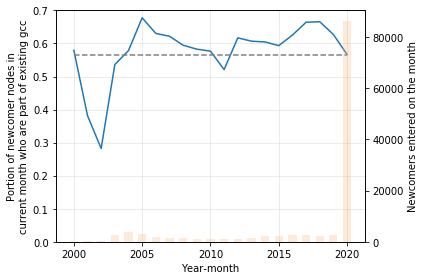

In [94]:
fig,ax = plt.subplots( #figsize = (24,5)
                     )
keys,values = zip(*sorted(dict_portion_new_nodes_in_gcc_by_quarter.items()))
keys, values = np.array(keys).astype(int), np.array(values)
boolean = np.array(keys) > 1999
ax.plot(keys[boolean], np.array(values)[boolean])
value_2020 = values[np.argwhere(keys==2020).T[0]][0]
value_2019 = values[np.argwhere(keys==2019).T[0]][0]
plt.plot([min(keys[boolean]), max(keys[boolean])], [value_2020, value_2020], c='grey', linestyle='dashed')
print('Percent handheld in 2020: ' + str(round(value_2020 * 100, 1)) + '%')
print('Percent handheld in 2019: ' + str(round(value_2019 * 100, 1)) + '%')
plt.ylim(0, 0.7)
ax_newcomer_count = ax.twinx()


timewindows, newcomer_counts = zip(*sorted({k:len(v) for k,v in dict_newcomer_nodes_by_year_quarter.items()}.items()))
timewindows, newcomer_counts = np.array(timewindows).astype(int), np.array(newcomer_counts)
boolean = np.array(timewindows) > 1999
ax_newcomer_count.bar(timewindows[boolean],np.array(newcomer_counts)[boolean],
                      width=0.6, alpha=0.3, zorder = 5, color = "#fdbb84")

#ax_newcomer_count.set_yscale('log')
ax.set_xticks([key for e, key in enumerate(keys[boolean]) if e % 5 == 0])
# ax.set_xticklabels(keys,rotation=90)
## Indicating the First quarter of 2020
# ax.axvline(np.argwhere(keys == 2020)[0][0], color = "red")
# ax.set_xlim(np.argwhere(keys == 2020)[0][0]-52,len(keys)+1)
ax.grid(alpha = 0.3)
#fig.tight_layout()
ax.set_xlabel("Year-month")
ax.set_ylabel("Portion of newcomer nodes in\ncurrent month who are part of existing gcc")
ax_newcomer_count.set_ylabel("Newcomers entered on the month")
plt.tight_layout()
plt.savefig("../outputs/figures/%s_monthly_portion_of_newcomers_part_of_gcc.png" %output_code, dpi = 150)
plt.show()

# Within a single year

In [132]:
def get_dateinfox_from_a_string_datetime(s):
    #return datetime.datetime.strptime(s,"%Y-%m-%d").month # get month
    return datetime.datetime.strptime(s,"%Y-%m-%d").isocalendar()[1] # get week

Edited code to drop Jan 1, 2020 publications.

In [197]:
searchterm = ''

In [198]:
article_authors_filtered["year_month"] = article_authors_filtered["converted_datetime"].apply(
    lambda x: str(pd.Timestamp(x).year) +"-%02d"%(get_dateinfox_from_a_string_datetime(x))
)

article_authors_filtered2 = article_authors_filtered[
    article_authors_filtered["converted_datetime"] != '2020-01-01'
]
cord_ids = metadata[metadata['abstract'].fillna('').str.lower().str.contains(searchterm)]['cord_uid']
article_authors_filtered2 = article_authors_filtered2[article_authors_filtered2['cord_uid'].isin(cord_ids)]

earliest_publication = article_authors_filtered2[['author_id', 'converted_datetime']].groupby('author_id')\
            .min()[['converted_datetime']].reset_index()
earliest_publication["year_month"] = earliest_publication["converted_datetime"].apply(
    lambda x: str(pd.Timestamp(x).year) +"-%02d"%(get_dateinfox_from_a_string_datetime(x))
)

In [199]:
dict_newcomer_nodes_by_year_quarter = earliest_publication.groupby("year_month")["author_id"].apply(set).to_dict()

In [200]:
dict_portion_new_nodes_in_gcc_by_quarter = return_dict(article_authors_filtered2)

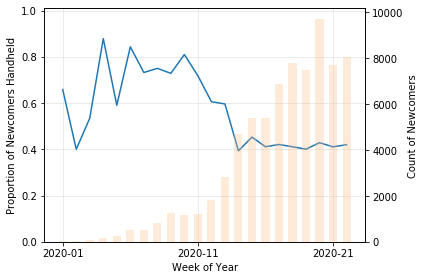

In [201]:
fig,ax = plt.subplots(
    #figsize = (24,5)
)
# Percent handheld
keys, values = zip(*sorted(dict_portion_new_nodes_in_gcc_by_quarter.items()))
keys, values = np.array(keys), np.array(values)
boolean = (keys < '2020-23') & (keys >= '2020-01')
values = values[boolean]; keys = keys[boolean]
ax.plot(keys, values)
plt.ylim(0, 1.01)
ax_newcomer_count = ax.twinx()

# Newcomper counts
keys2, values2 = zip(*sorted({k:len(v) for k,v in dict_newcomer_nodes_by_year_quarter.items()}.items()))
keys2, values2 = np.array(keys2), np.array(values2)
boolean = (keys2 < '2020-23') & (keys2 >= '2020-01')
values2 = values2[boolean]; keys2 = keys2[boolean]
ax_newcomer_count.bar(keys2, values2 ,width=0.6, alpha=0.3, zorder = 5, color = "#fdbb84")


#ax_newcomer_count.set_yscale('log')
xticks = [keys for e, keys in enumerate(keys) if e % 10 == 0]
xtick_indices = [e for e, keys in enumerate(keys) if e % 10 == 0]
plt.xticks(xtick_indices, xticks, rotation=45)

ax.grid(alpha = 0.3)
#fig.tight_layout()
ax.set_xlabel("Week of Year")
ax.set_ylabel("Proportion of Newcomers Handheld")
ax_newcomer_count.set_ylabel("Count of Newcomers")
plt.tight_layout()
plt.savefig("../outputs/figures/%s_monthly_portion_of_newcomers_part_of_gcc.png" %output_code, dpi = 150)
plt.show()

In [202]:
n = 10
first_nwks = np.sum((values * values2)[0:n]) / np.sum(values2[0:n])
print(first_nwks)

n0, n1 = 14, len(values2)
nwks = np.sum((values * values2)[n0:n1]) / np.sum(values2[n0:n1])
print(nwks)

0.7589563056533444
0.4188142563399589


Numerical analysis